# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [1]:
#DO NOT EDIT THIS CELL
#Run this cell to install required packages.

# !pip install ipywidgets

#Next, click the jupyter icon, select the STARTER file, and shutdown.
#Then, return to the STARTER file. 

In [2]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [4]:
batch_size = 250

In [5]:
# Define transforms
## YOUR CODE HERE ##
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((.5,),(.5,))])

# Create training set and define training dataloader
## YOUR CODE HERE ##
training_data = torchvision.datasets.MNIST('data/train', train=True, transform=transform, download=True)
train_data, val_data = torch.utils.data.random_split(training_data, [50000, 10000])

train_loader = torch.utils.data.DataLoader(dataset=train_data, shuffle=True, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(dataset=val_data, shuffle=True, batch_size=batch_size)

/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
# Create test set and define test dataloader
## YOUR CODE HERE ##
test_data = torchvision.datasets.MNIST('data/test', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, shuffle=True, batch_size=batch_size)

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

**Normalization:** In my case, I have used transforms.Normalize((0.5,), (0.5,)), the mean and standard deviation are both set to 0.5. This means that each pixel value in the image tensor is first subtracted by 0.5, and then divided by 0.5. This results in pixel values that range from -1 to 1.

Normalization ensures that the pixel values of the images are scaled to a range that is suitable for the neural network. Specifically, normalization ensures that the pixel values have zero mean and unit variance. This helps the neural network converge faster and more reliably during training.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [7]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

1


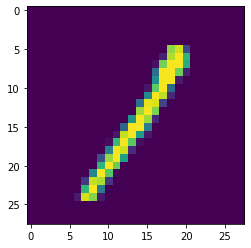

7


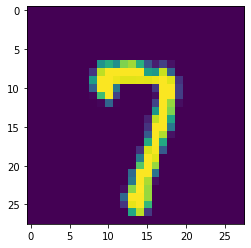

9


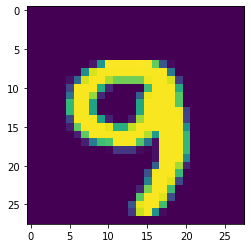

3


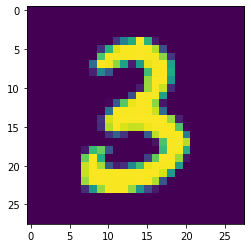

3


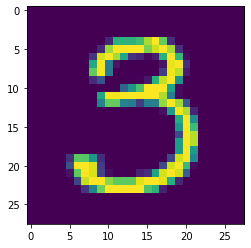

In [8]:
# Explore data
## YOUR CODE HERE ##
show5(test_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [9]:
## YOUR CODE HERE ##
input_dimension = training_data.data.shape[1] * training_data.data.shape[2]

In [10]:
# First Neural Network Model: MLP - multilayer perceptron
class MNIST_MLP(nn.Module):
    def __init__(self, input_dimension):
        super().__init__()
        self.activation = F.relu
        self.output = F.log_softmax
        self.fc1 = nn.Linear(input_dimension, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.output(self.fc3(x)) # For some output functions, may need to specify dimension.
        return x

# Do not change the name of your model or later cells may fail!
mlp = MNIST_MLP(input_dimension)
mlp.to(device)

MNIST_MLP(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [11]:
# First Neural Network Model: CNN - convolutional neural network
class MNIST_CNN(nn.Module):

    def __init__(self):
        super(MNIST_CNN, self).__init__()
        # TODO initialize model layers here
        self.conv2d_1 = nn.Conv2d(1, 28, (2, 2))
        self.maxPool2d = nn.MaxPool2d((2, 2))
        self.conv2d_2 = nn.Conv2d(28, 28*2, (2, 2))
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)
        self.linearL1 = nn.Linear(2016, 112)
        self.linearL2 = nn.Linear(112, 10)
        self.relu = F.relu
        self.log_softmax = F.log_softmax

    def forward(self, x):

        # TODO use model layers to predict the digit
        x = self.conv2d_1(x)
        x = self.relu(x)
        x = self.maxPool2d(x)
        x = self.conv2d_2(x)
        x = self.relu(x)
        x = self.maxPool2d(x)
        x = self.flatten(x)
        x = self.linearL1(x)
        x = self.dropout(x)
        x = self.linearL2(x)
        x = self.log_softmax(x)

        return x

# Do not change the name of your model or later cells may fail!
CNN = MNIST_CNN()
CNN.to(device)

MNIST_CNN(
  (conv2d_1): Conv2d(1, 28, kernel_size=(2, 2), stride=(1, 1))
  (maxPool2d): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2d_2): Conv2d(28, 56, kernel_size=(2, 2), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.5, inplace=False)
  (linearL1): Linear(in_features=2016, out_features=112, bias=True)
  (linearL2): Linear(in_features=112, out_features=10, bias=True)
)

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [12]:
## YOUR CODE HERE ##
num_epochs = 5

# We'll use cross entropy as our objective function here. 
criterion = nn.NLLLoss()
# criterion = nn.CrossEntropyLoss()

# Change the choice of optimizer here
optimizerMLP = optim.SGD(mlp.parameters(), lr=0.005, momentum=0.9)
optimizerCNN = optim.Adam(CNN.parameters(), lr=0.001)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [13]:
def train_network_classification(net, train_loader, test_loader, batch_size, num_epochs, criterion, optimizer):
    # Establish a list for our history
    train_loss_history = list()
    val_loss_history = list()

    for epoch in range(num_epochs):
        net.train()
        train_loss = 0.0
        train_correct = 0
        for i, data in enumerate(train_loader):
            # data is a list of [inputs, labels]
            inputs, labels = data

            # Pass to GPU if available.
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            _, preds = torch.max(outputs.data, 1)
            train_correct += (preds == labels).sum().item()
            train_loss += loss.item()
        train_size = len(train_loader) * batch_size
        print(f'Epoch {epoch + 1} training accuracy: {100*train_correct/train_size:.2f}% training loss: {train_loss/train_size:.5f}')
        train_loss_history.append(train_loss)

        
        val_loss = 0.0
        val_correct = 0
        net.eval()
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
        
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            
            _, preds = torch.max(outputs.data, 1)
            val_correct += (preds == labels).sum().item()
            val_loss += loss.item()
        val_size = len(test_loader) * batch_size
        print(f'Epoch {epoch + 1} validation accuracy: {100*val_correct/val_size:.2f}% validation loss: {val_loss/val_size:.5f}')
        val_loss_history.append(val_loss)           

    plt.plot(train_loss_history, label="Training Loss")
    plt.plot(val_loss_history, label="Validation Loss")
    plt.legend()
    plt.show()

Plot the training loss (and validation loss/accuracy, if recorded).

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  


Epoch 1 training accuracy: 69.18% training loss: 0.00439
Epoch 1 validation accuracy: 87.19% validation loss: 0.00176
Epoch 2 training accuracy: 89.21% training loss: 0.00150
Epoch 2 validation accuracy: 90.20% validation loss: 0.00137
Epoch 3 training accuracy: 90.84% training loss: 0.00125
Epoch 3 validation accuracy: 90.92% validation loss: 0.00125
Epoch 4 training accuracy: 91.75% training loss: 0.00111
Epoch 4 validation accuracy: 91.81% validation loss: 0.00113
Epoch 5 training accuracy: 92.48% training loss: 0.00102
Epoch 5 validation accuracy: 92.12% validation loss: 0.00104


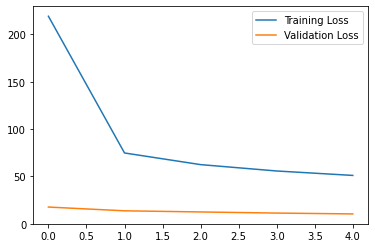

In [14]:
# Now let's train our MLP
train_network_classification(mlp, train_loader, val_loader, batch_size, num_epochs, criterion, optimizerMLP)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1 training accuracy: 88.36% training loss: 0.00159
Epoch 1 validation accuracy: 96.77% validation loss: 0.00045
Epoch 2 training accuracy: 96.69% training loss: 0.00045
Epoch 2 validation accuracy: 97.67% validation loss: 0.00031
Epoch 3 training accuracy: 97.62% training loss: 0.00032
Epoch 3 validation accuracy: 98.24% validation loss: 0.00024
Epoch 4 training accuracy: 97.94% training loss: 0.00028
Epoch 4 validation accuracy: 98.51% validation loss: 0.00021
Epoch 5 training accuracy: 98.21% training loss: 0.00023
Epoch 5 validation accuracy: 98.32% validation loss: 0.00020


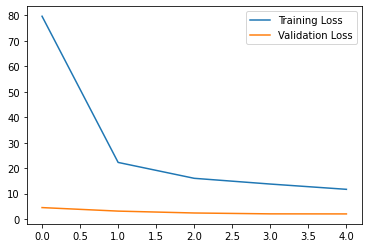

In [15]:
## YOUR CODE HERE ##
train_network_classification(CNN, train_loader, val_loader, batch_size, num_epochs, criterion, optimizerCNN)

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  


Epoch 1 training accuracy: 93.11% training loss: 0.00094
Epoch 1 validation accuracy: 93.34% validation loss: 0.00090
Epoch 2 training accuracy: 93.58% training loss: 0.00087
Epoch 2 validation accuracy: 93.80% validation loss: 0.00084
Epoch 3 training accuracy: 94.13% training loss: 0.00080
Epoch 3 validation accuracy: 94.26% validation loss: 0.00077
Epoch 4 training accuracy: 94.57% training loss: 0.00074
Epoch 4 validation accuracy: 94.52% validation loss: 0.00075
Epoch 5 training accuracy: 94.97% training loss: 0.00069
Epoch 5 validation accuracy: 94.71% validation loss: 0.00072


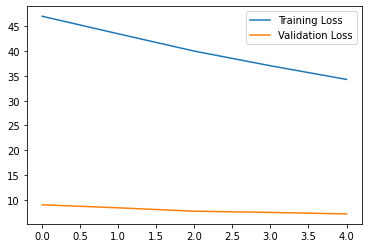

In [19]:
## YOUR CODE HERE ##
train_network_classification(mlp, train_loader, test_loader, batch_size, num_epochs, criterion, optimizerMLP)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1 training accuracy: 98.42% training loss: 0.00021
Epoch 1 validation accuracy: 98.64% validation loss: 0.00018
Epoch 2 training accuracy: 98.52% training loss: 0.00019
Epoch 2 validation accuracy: 98.72% validation loss: 0.00016
Epoch 3 training accuracy: 98.72% training loss: 0.00017
Epoch 3 validation accuracy: 98.58% validation loss: 0.00017
Epoch 4 training accuracy: 98.84% training loss: 0.00015
Epoch 4 validation accuracy: 98.83% validation loss: 0.00015
Epoch 5 training accuracy: 98.91% training loss: 0.00014
Epoch 5 validation accuracy: 98.87% validation loss: 0.00016


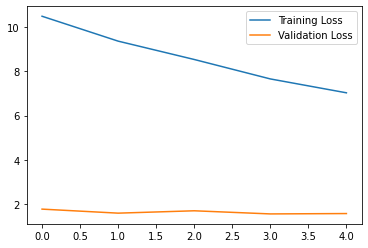

In [20]:
## YOUR CODE HERE ##
train_network_classification(CNN, train_loader, test_loader, batch_size, num_epochs, criterion, optimizerCNN)

## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [17]:
## YOUR CODE HERE ##

## Saving your model
Using `torch.save`, save your model for future loading.

In [21]:
## YOUR CODE HERE ##
# Save the model to a file
torch.save(mlp.state_dict(), 'MNIST_mlp.pt')
torch.save(CNN.state_dict(), 'MNIST_CNN.pt')